# Greatest Python Deep Learning Tutorial EVER...
Theano introduction example with MNIST, babysteps, simple to understand, easy to follow. No tricks. Other python deep learning tutorial suffer from *"death by wrappers"* where they wrap so many libraries you begin to wonder what you are actually driving. Also, deep learning is a simple enough concept you should be able to comprehend it from the ground up. This tutorial was built by @bentaylordata. If you have any ideas to make it better place make updates.
![caption](http://7-themes.com/data_images/out/37/6896773-amazing-wallpaper.jpg)

## Let's Grab Some Data! Hello World Deep Learning Example ~ MNIST 

In [50]:
from sklearn import datasets
import numpy as np
dataset = datasets.fetch_mldata("MNIST Original")
X = dataset.data
Y = dataset.target

In [51]:
print X.shape

(70000, 784)


In [52]:
print "So we have",X.shape[0],"hand written digit images. The images have been flattened where 28x28 =",X.shape[1]
print "The labels are a vector ",len(Y),"long. With unique values:",np.unique(Y)

So we have 70000 hand written digit images. The images have been flattened where 28x28 = 784
The labels are a vector  70000 long. With unique values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


# Concept Of A Tensor

In [53]:
X_tensor = X.reshape((X.shape[0],1,28,28))
print "We have reshaped",X.shape,"into",X_tensor.shape,". This is the format we want for convolutional nets"

We have reshaped (70000, 784) into (70000, 1, 28, 28) . This is the format we want for convolutional nets


Now Create Smart Train/Test Splits for training where we can train on **86%** of the data and test on **14%** using a 7 k-fold. 

In [54]:
from sklearn.cross_validation import StratifiedKFold
stratified_k_fold_splits = StratifiedKFold(Y, n_folds=7,shuffle=True)
for train_index, test_index in stratified_k_fold_splits: break  #Just take for the first one

In [55]:
np.random.shuffle(train_index)     # Index shuffle not working? Force here
np.random.shuffle(test_index)      # Index shuffle not working? Force here
X_train, Y_train = X_tensor[train_index], Y[train_index]
X_test, Y_test = X_tensor[test_index], Y[test_index]

Now Create A Second Training Validation Set To Use For An Optimizations

In [56]:
stratified_k_fold_splits = StratifiedKFold(Y_train, n_folds=7,shuffle=True)
for train_train_index, train_test_index in stratified_k_fold_splits: break  #Just take for the first one
X_train_train, Y_train_train = X_tensor[train_index][train_train_index], Y[train_index][train_train_index]
X_train_test, Y_train_test = X_tensor[train_index][train_test_index], Y[train_index][train_test_index]

In [57]:
print "Our training set is:",X_train.shape
print "     Our training (train) set is:",X_train_train.shape
print "     Our training (test) set is:",X_train_test.shape
print "Our testing set is:",X_test.shape

Our training set is: (59996, 1, 28, 28)
     Our training (train) set is: (51422, 1, 28, 28)
     Our training (test) set is: (8574, 1, 28, 28)
Our testing set is: (10004, 1, 28, 28)


In [58]:
def to_categorical(y, nb_classes=None):
    '''Convert class vector (integers from 0 to nb_classes)
    to binary class matrix, for use with categorical_crossentropy
    '''
    y = np.asarray(y, dtype='int32')
    if not nb_classes:
        nb_classes = np.max(y)+1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1.
    return Y

In [59]:
Y_train = to_categorical(Y_train)                 # Convert Ys to matrix onehotencoded format for training
Y_test = to_categorical(Y_test)
Y_train_train = to_categorical(Y_train_train)
Y_train_test = to_categorical(Y_train_test)
print Y_train.shape

(59996, 10)


In [60]:
Y_train[0:2,:]

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## Data Set Preview, what are we actually doing?
When dealing with image data it is always nice to preview it to see if you have messed up on the reshape, tranpose, etc... For the MNIST hand written dataset lets take a look at our numbers.

(-0.5, 279.5, 27.5, -0.5)

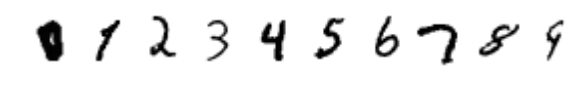

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline 
for number in range(0,10):
    if number==0:
        image_stack = X_train[np.argmax(Y_train,axis=1)==number][0][0]
    else:
        image_stack = np.hstack((image_stack,X_train[np.argmax(Y_train,axis=1)==number][0][0]))
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.imshow(image_stack,cmap=plt.get_cmap('gray_r'))
plt.axis('off')

In [62]:
print X_train.shape
print Y_train.shape

(59996, 1, 28, 28)
(59996, 10)


# Deep Learning Building Blocks
Here are some simple building blocks for deep learning to help our model. 

In [63]:
import theano
import theano.tensor as T
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.downsample import max_pool_2d
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
srng = RandomStreams()

In [64]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def rectify(X):
    return T.maximum(X, 0.)

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

In [65]:
def sgd(cost, params, lr=0.05, momentum = 0.9):         # Stochastic gradient decent
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new =  acc*momentum + (1.0-momentum)*g
        updates.append([acc, acc_new])
        updates.append([p, p - acc_new * lr])
    return updates

# Define / Build A Deep Learning Model
Now we will design a deep learning model for the MNIST data set that uses convolutions, dropout, and maxpooling

In [66]:
def model(X, w, p_drop_conv, p_drop_hidden):
    layer1 = rectify(conv2d(X, w[0], border_mode='full'))
    layer1 = max_pool_2d(layer1, (2, 2),ignore_border=True)
    layer1 = dropout(layer1, p_drop_conv)

    layer2 = rectify(conv2d(layer1, w[1]))
    layer2 = max_pool_2d(layer2, (2, 2),ignore_border=True)
    layer2 = dropout(layer2, p_drop_conv)

    layer3 = rectify(conv2d(layer2, w[2]))
    layer3 = max_pool_2d(layer3, (2, 2),ignore_border=True)
    layer3 = T.flatten(layer3, outdim=2)
    layer3 = dropout(layer3, p_drop_conv)

    layer4 = rectify(T.dot(layer3, w[3]))
    layer4 = dropout(layer4, p_drop_hidden)

    pyx = softmax(T.dot(layer4, w_o))
    return pyx

# Define Backend Theano Functions To Initialize And Do The Work

In [67]:
trX=floatX(X_train)/255.0
trY=floatX(Y_train)
teX=floatX(X_test)/255.0
teY=floatX(Y_test)
X = T.ftensor4()
Y = T.fmatrix()

In [68]:
w = init_weights((32, 1, 3, 3))
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((512, 625))
w_o = init_weights((625, 10))

noise_py_x = model(X, [w, w2, w3, w4], 0.2, 0.5)
py_x = model(X, [w, w2, w3, w4], 0., 0.)
y_x = T.argmax(py_x, axis=1)

params = [w, w2, w3, w4, w_o]
cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
updates = sgd(cost, params, lr=0.1)

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [69]:
for epoch in range(6):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        epoch_cost = train(trX[start:end], trY[start:end])
    print "Epoch:",epoch,"Cost:",epoch_cost," Accuracy:",np.mean(np.argmax(teY, axis=1) == predict(teX))*100,"percent"

Epoch: 0 Cost: 2.30258178711  Accuracy: 13.9244302279 percent
Epoch: 1 Cost: 2.3025841713  Accuracy: 23.5105957617 percent
Epoch: 2 Cost: 2.30256748199  Accuracy: 27.4390243902 percent
Epoch: 3 Cost: 2.30256462097  Accuracy: 27.5489804078 percent
Epoch: 4 Cost: 2.30254602432  Accuracy: 25.449820072 percent
Epoch: 5 Cost: 2.30252218246  Accuracy: 21.2415033986 percent


In [70]:
def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

In [71]:
w = init_weights((32, 1, 3, 3))
w2 = init_weights((64, 32, 3, 3))
w3 = init_weights((128, 64, 3, 3))
w4 = init_weights((128 * 4, 625))
w_o = init_weights((625, 10))

updates = RMSprop(cost, params, lr=0.001)
train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)

In [72]:
for epoch in range(6):
    for start, end in zip(range(0, len(trX), 128), range(128, len(trX), 128)):
        epoch_cost = train(trX[start:end], trY[start:end])
    print "Epoch:",epoch,"Cost:",epoch_cost," Accuracy:",np.mean(np.argmax(teY, axis=1) == predict(teX))*100,"percent"

Epoch: 0 Cost: 0.138572543859  Accuracy: 95.7616953219 percent
Epoch: 1 Cost: 0.0726499184966  Accuracy: 97.7409036385 percent
Epoch: 2 Cost: 0.0287853199989  Accuracy: 98.4806077569 percent
Epoch: 3 Cost: 0.0341680794954  Accuracy: 98.7205117953 percent
Epoch: 4 Cost: 0.0240500755608  Accuracy: 98.9204318273 percent
Epoch: 5 Cost: 0.0267007853836  Accuracy: 98.9904038385 percent


# Ok.... Now Lets Try A Theano Wrapper
The great thing about Theano is you can understand EVERYTHING. There are some simple wrappers above Theano that make
this process easier and offer more tools. My favorite is Keras.io. Check it out. 

In [73]:
import sys,os
sys.path.insert(0, "/home/ubuntu/keras")
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [76]:
def define_model(optimizer_algo):
    model = Sequential()

    model.add(Convolution2D(32, 1, 3, 3,border_mode='full'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, 32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(128, 64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128*4,625))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(625,10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer_algo)
    return model

In [77]:
model = define_model('RMSprop')
log_fit1 = model.fit(trX, trY, 
                    batch_size=128, 
                    nb_epoch=6, 
                    show_accuracy=True, 
                    verbose=1, 
                    validation_data=(teX, teY))

Train on 59996 samples, validate on 10004 samples
Epoch 1/6
59996/59996 [==============================] - 10s - loss: 0.3411 - acc: 0.8891 - val_loss: 0.0843 - val_acc: 0.9742
Epoch 2/6
59996/59996 [==============================] - 10s - loss: 0.0814 - acc: 0.9742 - val_loss: 0.0480 - val_acc: 0.9857
Epoch 3/6
59996/59996 [==============================] - 10s - loss: 0.0566 - acc: 0.9830 - val_loss: 0.0483 - val_acc: 0.9855
Epoch 4/6
59996/59996 [==============================] - 10s - loss: 0.0437 - acc: 0.9857 - val_loss: 0.0360 - val_acc: 0.9891
Epoch 5/6
59996/59996 [==============================] - 10s - loss: 0.0366 - acc: 0.9881 - val_loss: 0.0311 - val_acc: 0.9908
Epoch 6/6
59996/59996 [==============================] - 10s - loss: 0.0332 - acc: 0.9890 - val_loss: 0.0270 - val_acc: 0.9925


In [78]:
model = define_model('adam')
log_fit2 = model.fit(trX, trY, 
                    batch_size=128, 
                    nb_epoch=6, 
                    show_accuracy=True, 
                    verbose=1, 
                    validation_data=(teX, teY))

Train on 59996 samples, validate on 10004 samples
Epoch 1/6
59996/59996 [==============================] - 10s - loss: 0.2848 - acc: 0.9086 - val_loss: 0.0724 - val_acc: 0.9782
Epoch 2/6
59996/59996 [==============================] - 10s - loss: 0.0698 - acc: 0.9780 - val_loss: 0.0434 - val_acc: 0.9874
Epoch 3/6
59996/59996 [==============================] - 10s - loss: 0.0501 - acc: 0.9840 - val_loss: 0.0424 - val_acc: 0.9875
Epoch 4/6
59996/59996 [==============================] - 10s - loss: 0.0403 - acc: 0.9875 - val_loss: 0.0300 - val_acc: 0.9909
Epoch 5/6
59996/59996 [==============================] - 10s - loss: 0.0349 - acc: 0.9888 - val_loss: 0.0314 - val_acc: 0.9903
Epoch 6/6
59996/59996 [==============================] - 10s - loss: 0.0283 - acc: 0.9906 - val_loss: 0.0277 - val_acc: 0.9923


In [79]:
model = define_model('sgd')
log_fit3 = model.fit(trX, trY, 
                    batch_size=128, 
                    nb_epoch=6, 
                    show_accuracy=True, 
                    verbose=1, 
                    validation_data=(teX, teY))

Train on 59996 samples, validate on 10004 samples
Epoch 1/6
59996/59996 [==============================] - 10s - loss: 2.1071 - acc: 0.2961 - val_loss: 1.4942 - val_acc: 0.7422
Epoch 2/6
59996/59996 [==============================] - 10s - loss: 0.9358 - acc: 0.7055 - val_loss: 0.4798 - val_acc: 0.8649
Epoch 3/6
59996/59996 [==============================] - 10s - loss: 0.5212 - acc: 0.8345 - val_loss: 0.3159 - val_acc: 0.9088
Epoch 4/6
59996/59996 [==============================] - 10s - loss: 0.3863 - acc: 0.8784 - val_loss: 0.2343 - val_acc: 0.9306
Epoch 5/6
59996/59996 [==============================] - 10s - loss: 0.3168 - acc: 0.8998 - val_loss: 0.1934 - val_acc: 0.9430
Epoch 6/6
59996/59996 [==============================] - 10s - loss: 0.2705 - acc: 0.9147 - val_loss: 0.1662 - val_acc: 0.9514


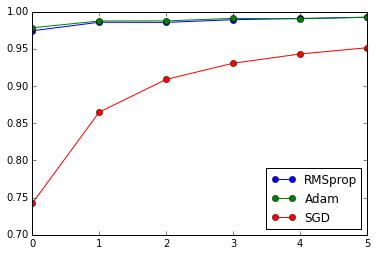

In [80]:
plt.plot(log_fit1.history['val_acc'],'o-',label='RMSprop')
plt.plot(log_fit2.history['val_acc'],'o-',label='Adam')
plt.plot(log_fit3.history['val_acc'],'o-',label='SGD')
plt.legend(loc=0)

# Data Augmentation
Data augmentation can really help make your models more robust. This helps boost accuracy in most cases

In [81]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import generic_utils
from keras.datasets import cifar10

In [82]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [90]:
print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

('X_train shape:', (50000, 3, 32, 32))
(50000, 'train samples')
(10000, 'test samples')


In [91]:
def define_color_model(optimizer_algo):
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, 3,border_mode='full'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(64, 32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Convolution2D(128, 64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128*4,625))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(625,10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer_algo)
    return model

In [92]:
model = define_color_model('adam')

(-0.5, 95.5, 31.5, -0.5)

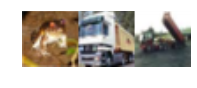

In [86]:
fig=plt.gcf()
fig.set_size_inches(3,1)
im1=np.array(np.transpose(x_train[0],axes=[1,2,0]))
im2=np.array(np.transpose(x_train[1],axes=[1,2,0]))
im3=np.array(np.transpose(x_train[2],axes=[1,2,0]))
plt.imshow(np.hstack((im1,im2,im3)))
plt.axis("off")

In [87]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [88]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [95]:
for e in range(6):
    print('-'*40)
    print('Epoch', e)
    print('-'*40)
    print("Training...")
    # batch train with realtime data augmentation
    progbar = generic_utils.Progbar(x_train.shape[0])
    for x_batch, y_batch in datagen.flow(x_train, y_train):
        loss = model.train_on_batch(x_batch, y_batch)
        progbar.add(x_batch.shape[0], values=[("train loss", loss)])

    print("Testing...")
    # test time!
    progbar = generic_utils.Progbar(x_test.shape[0])
    for x_batch, y_batch in datagen.flow(x_test, y_test):
        score = model.test_on_batch(x_batch, y_batch)
        progbar.add(x_batch.shape[0], values=[("test loss", score)])

----------------------------------------
('Epoch', 0)
----------------------------------------
Training...
50000/50000 [==============================] - 219s - train loss: 1.3917   
Testing...
10000/10000 [==============================] - 41s - test loss: 1.3864    
----------------------------------------
('Epoch', 1)
----------------------------------------
Training...
 1344/50000 [..............................] - ETA: 212s - train loss: 1.3863

KeyboardInterrupt: 

# Prevent GPU starving...
Use your CPUs for preprocessing data augmentation batches

In [96]:
import os
if not os.path.exists('buffering.py'):
    print('Downloading buffering.py')
    os.system('wget https://raw.githubusercontent.com/benanne/kaggle-ndsb/11a66cdbddee16c69514b9530a727df0ac6e136f/buffering.py')
from buffering import buffered_gen_mp, buffered_gen_threaded

In [ ]:
for e in range(6):
    print('-'*40)
    print('Epoch', e)
    print('-'*40)
    print("Training...")
    # batch train with realtime data augmentation
    progbar = generic_utils.Progbar(X_train.shape[0])
    for X_batch, Y_batch in buffered_gen_threaded(datagen.flow(X_train, Y_train),buffer_size=8):
        loss, acc = model.train_on_batch(X_batch, Y_batch, accuracy=True)
        progbar.add(X_batch.shape[0], values=[("train loss", loss),("train acc", acc)])

    print("Testing...")
    # test time!
    progbar = generic_utils.Progbar(X_test.shape[0])
    #p = np.array(np.zeros_like(Yp),dtype=float)
    for X_batch, Y_batch in datagen.flow(X_test, Y_test):
        #p = model.predict_on_batch(X_batch)
        score, acc = model.test_on_batch(X_batch, Y_batch, accuracy=True)
        progbar.add(X_batch.shape[0], values=[("test loss", score),("test acc", acc)])

In [ ]:
# More Advanced Activations, leaky, etc..

In [ ]:
# More Advanced Max Pooling, Fractional Max Pooling

In [ ]:
# More Advanced Data Augementation

In [ ]:
# Lessons Gotchas:
    # Want sorted types in batches
    # Weight initialization strategies
    # Optimizations, key to success
    # Don't Get Fooled By Imbalance Accuracies
    # Don't CHEAT!! 

In [ ]:
# Add genetic deep nets, or gradient boosting deep nets